#Colab principal
Rajoutez uniqument le code propre et commenté dans la partie code.  

# Environment settings

## Drive mounting

Il faut mount le drive en executant le code ci dessous. Rajoutez uniquement votre code propre et qui marche. Travaillez sur votre brouillon autrement.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Import self made libraries


Pour importer des fichier externes en python vous pouvez utiliser ça:

In [0]:
import sys
sys.path.insert(0, '/content/gdrive/My Drive/Colab Notebooks/my_modules')

import naive_sharding

# Start of code

In [0]:
!pip install vaderSentiment

     |████████████████████████████████| 133kB 2.8MB/s 


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import re
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import os
import matplotlib.pyplot as plt

# Pathfiles
pd.set_option('display.max_colwidth', -1)
tweet_datapath = "/content/drive/Shared drives/ADA/Data_Tweets/"

## Weather Pipeline


Get the weather 

In [0]:
def parse_weather_file(file,n_col,city):
    data = []
    with open(file, 'r') as file_object:
        for ind,line in enumerate(file_object):
            if ind==10:
                col = line.split(',')
            elif ind>11:
                line = line
                line_split = line.split(',')
                
                if(len(line_split)==n_col):
                    line_split[-1]=[line_split[-1].replace('\n','')]
                    data.append(line_split)
                elif(len(line_split)<n_col):
                  counterless+=1
                elif(len(line_split)>n_col):
                  
                  line_split[n_col-1]=[l.replace('\n','') for l in line_split[n_col:]]
                  data.append(line_split[:n_col])
                elif(len(line_split)>n_col+2):
                  countermore+=1
                  lenght.append(len(line_split))
                  bis.append(line_split)
                else:
                    pass
    df = pd.DataFrame(data)
    df.columns = col
    df['location'] = city
    df['Date_Time'] = pd.to_datetime(df['Date_Time'])
    return df

In [0]:
NY_weather = parse_weather_file(tweet_datapath+'meteo_csv/NY_weather.csv',36,'New York')
LA_weather = parse_weather_file(tweet_datapath+'meteo_csv/LA_weather.csv',36,'Los Angeles')
ATL_weather = parse_weather_file(tweet_datapath+'meteo_csv/ATL_weather.csv',37,'Atlanta')
CHI_weather = parse_weather_file(tweet_datapath+'meteo_csv/CHI_weather.csv',37,'Chicago')

In [0]:
weather = pd.concat([NY_weather,LA_weather,ATL_weather,CHI_weather],sort=True)
weather.head()

,Date_Time,Station_ID,air_temp_high_24_hour_set_1,air_temp_high_6_hour_set_1,air_temp_low_24_hour_set_1,air_temp_low_6_hour_set_1,air_temp_set_1,altimeter_set_1,ceiling_set_1,cloud_layer_1_code_set_1,cloud_layer_2_code_set_1,cloud_layer_3_code_set_1,dew_point_temperature_set_1,dew_point_temperature_set_1d,heat_index_set_1d,location,metar_set_1,peak_wind_direction_set_1,peak_wind_speed_set_1,precip_accum_24_hour_set_1,precip_accum_one_hour_set_1,precip_accum_six_hour_set_1,precip_accum_three_hour_set_1,pressure_change_code_set_1,pressure_set_1d,pressure_tendency_set_1,relative_humidity_set_1,sea_level_pressure_set_1,sea_level_pressure_set_1d,snow_depth_set_1,visibility_set_1,weather_cond_code_set_1,weather_condition_set_1d\n,wind_cardinal_direction_set_1d,wind_chill_set_1d,wind_direction_set_1,wind_gust_set_1,wind_speed_set_1
0,2009-04-01 00:51:00+00:00,KNYC,,,,,7.8,101768.99,,1.0,,,,-0.09,,New York,,,,,,,,,101204.43,,57.77,102250.0,101783.37,NaN,10.0,,[Clear],,,,7.2,3.09
1,2009-04-01 01:51:00+00:00,KNYC,,,,,7.2,101735.32,,1.0,,,,-0.08,,New York,,,,,,,,,101170.94,,60.19,102210.0,101750.93,NaN,10.0,,[Clear],SE,,140.0,,4.12
2,2009-04-01 02:51:00+00:00,KNYC,,,,,6.7,101768.99,,1.0,,,,1.03,,New York,,,,,,,,,101204.43,1009.0,67.44,102260.0,101785.65,NaN,10.0,,[Clear],SSE,,160.0,,2.57
3,2009-04-01 03:51:00+00:00,KNYC,,,,,6.1,101870.02,,1.0,,,,1.64,,New York,,,,,,,,,101304.89,,73.38,102340.0,101887.94,NaN,10.0,,[Clear],SSE,,150.0,,3.09
4,2009-04-01 04:51:00+00:00,KNYC,15.6,,3.3,,6.1,101870.02,,1.0,,,,2.15,,New York,,,,,,,,,101304.89,,76.05,102350.0,101887.94,NaN,10.0,,[Clear],SSE,,160.0,,3.09


Clean weather dataset and arbitrary weather condition grading 

In [0]:
def grade_weather(weather_conds):
    weather_dict ={}
    weather_dict[3] = ['Clear','Mostly Clear']
    weather_dict[2] = ['Overcast','Mostly Cloudy','Partly Cloudy']
    weather_dict[1] = ['Mist','Haze','Fog','Light Drizzle','Ice Fog','Smoke','Squalls']
    weather_dict[0] = ['Light Rain','Thunder','Light Rain/Thunderstorm','Rain','Heavy Rain',\
                       'Thunderstorm','Heavy Rain/Thunderstorm','Light Ice Pellets',\
                       'Unknown Precip','Light Frz Rain','Ice pellets','Heavy Hail','Hail',
                       'Squalls']
    snow = ['Light Snow','Blowing Snow','Snow']
    grade = []
    snowing = False
    for w in weather_conds:
        for ind in weather_dict:
            if w in weather_dict[ind]:
                grade.append(ind)
            elif w in snow:
                snowing = True
          
    if snowing:
        return 'snow'
    elif grade:
        return min(grade)
    else:
        return None 

def clean_and_grade_weather(weather_df):
    
    weather_df.loc[:,'weather_cond']=weather_df['weather_condition_set_1d\n'].map(lambda conds : grade_weather(conds))
    weather_df.loc[:,'precip_hour'] = weather['precip_accum_one_hour_set_1'].replace(r'^\s*$', np.nan, regex=True).map(lambda x : float(x)) # checker que fill avec 0 c'est correcte
    weather_df.loc[:,'temperature'] = weather['air_temp_set_1'].replace(r'^\s*$', np.nan, regex=True).map(lambda x : float(x))
    weather_df.loc[:,'pression'] = weather['pressure_set_1d'].replace(r'^\s*$', np.nan, regex=True).map(lambda x : float(x))
    weather_df.loc[:,'humidity'] = weather['relative_humidity_set_1'].replace(r'^\s*$', np.nan, regex=True).map(lambda x : float(x))
    weather_df.loc[:,'visibility'] = weather['visibility_set_1'].replace(r'^\s*$', np.nan, regex=True).map(lambda x : float(x))
    weather_df.loc[:,'wind_speed'] = weather['wind_speed_set_1'].replace(r'^\s*$', np.nan, regex=True).map(lambda x : float(x))
    weather_df.loc[:,'date/time'] = weather['Date_Time']
    to_keep = ['date/time','location','weather_cond','precip_hour','temperature','pression','humidity','wind_speed','visibility']

    return weather_df[to_keep].dropna(subset=['weather_cond'])

In [0]:
weather_cleaned=clean_and_grade_weather(weather)
weather_cleaned.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:376: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  self.obj[key] = _infer_fill_value(value)


,date/time,location,weather_cond,precip_hour,temperature,pression,humidity,wind_speed,visibility
0,2009-04-01 00:51:00+00:00,New York,3,NaN,7.8,101204.43,57.77,3.09,10.0
1,2009-04-01 01:51:00+00:00,New York,3,NaN,7.2,101170.94,60.19,4.12,10.0
2,2009-04-01 02:51:00+00:00,New York,3,NaN,6.7,101204.43,67.44,2.57,10.0
3,2009-04-01 03:51:00+00:00,New York,3,NaN,6.1,101304.89,73.38,3.09,10.0
4,2009-04-01 04:51:00+00:00,New York,3,NaN,6.1,101304.89,76.05,3.09,10.0


Averaging of weather hourly and daily. For the daily average, we keep only the data from 6 am to midnight because we suppose twitting people spend their night inside.

In [0]:
def average_time_hourly(df_weather):
    df = df_weather.copy()
    df['date/time']=df['date/time'].apply(lambda time : time.replace( minute=0, second=0, microsecond=0))
    df_avg = pd.DataFrame(columns=df.columns)
    to_mean =['precip_hour','temperature','pression','humidity','visibility','wind_speed']
    for ind,time in enumerate(df['date/time'].unique()):
        for ind_,city in enumerate(df['location'].unique()):
            df_it =  df[(df['date/time'] == time) & (df['location'] == city)]
            if df_it.shape[0]:
                df_avg.at[ind+ind_*9000,to_mean] = df_it[to_mean].mean(numeric_only=True)
                df_avg.at[ind+ind_*9000,'date/time']= time
                df_avg.at[ind+ind_*9000,'location']= city
                if 'snow' in df_it.weather_cond.values:
                    df_avg.at[ind+ind_*9000,'weather_cond']= 'snow'
                else: 
                    if list(df_it.weather_cond.values):
                        df_avg.at[ind+ind_*9000,'weather_cond']= Counter(df_it.weather_cond.values).most_common()[0][0] # keep the more represented and if there is equality, the worse weather condition
    df_avg.index = range(df_avg.shape[0])                
    return df_avg

def average_time_daily(df_weather):
    df = df_weather[df_weather['date/time'].apply(lambda datetime : datetime.hour>5)].copy()
    df['date/time']=df['date/time'].apply(lambda time : time.replace( hour=0,minute=0, second=0, microsecond=0))
    df_avg = pd.DataFrame(columns=df.columns)
    to_mean =['precip_hour','temperature','pression','humidity','visibility','wind_speed']
    for ind,time in enumerate(df['date/time'].unique()):
        for ind_,city in enumerate(df['location'].unique()):
            df_it = df[(df['date/time'] == time) & (df['location'] == city)]
            if df_it.shape[0]:
                df_avg.at[ind+ind_*365,to_mean] = df_it[to_mean].mean(numeric_only=True)
                df_avg.loc[ind+ind_*365,'date/time']= time
                df_avg.loc[ind+ind_*365,'location']= city
                if 'snow' in df_it.weather_cond.values:
                    df_avg.loc[ind+ind_*365,'weather_cond']= 'snow'
                else: 
                    if list(df_it.weather_cond.values):
                        df_avg.loc[ind+ind_*365,'weather_cond']=df_it.weather_cond.values #Counter(df_it.weather_cond.values).most_common()[0][0] # keep the more represented and if there is equality, the worse weather condition
    df_avg.index = range(df_avg.shape[0])
    return df_avg

In [0]:
weather_hourly=average_time_hourly(weather_cleaned)
weather_daily=average_time_daily(weather_cleaned)

In [0]:
weather_hourly.to_pickle(tweet_datapath+'meteo_csv/Weather_hourly')
weather_daily.to_pickle(tweet_datapath+'meteo_csv/Weather_daily')

## Tweets Pipeline

Ajouter partie de Max

# New Section

In [0]:
Tweets=pd.read_pickle(tweet_datapath+'data_frame_with_address.pickle')

In [0]:
analyzer = SentimentIntensityAnalyzer()
def get_sentiment(tweet):
    return analyzer.polarity_scores(tweet)
def adress_to_city(text):
  address = text.split(',')
  city=''
  if len(address)>3:
    city = address[-3]
  city = ' '.join(city.split())
  if city in ['Brooklyn','The Bronx']: # both are in New York
    city = 'New York'
  return city

In [0]:
Tweets.loc[:,'location']=''
Tweets.loc[:,'location'] = Tweets.Address.map(lambda text: adress_to_city(text)) #keep only city name from adress we get with google request from longitude and latitude
Tweets = Tweets.drop(columns=['longitude','latitude','Address'])

In [0]:
Tweets['sentiment'] = Tweets.tweet.map(lambda text: get_sentiment(text))

We only keep the biggest cities. New york is over-represented (600 000 tweet are from there)

In [0]:
cities =['New York','Los Angeles','Atlanta','Chicago']
Tweets = Tweets[Tweets.location.apply(lambda x : x in cities)]
Tweets.loc[:,'date/time']= pd.to_datetime(Tweets['date/time'], errors = 'coerce')
Tweets

,user_id,tweet_id,tweet,date/time,date,time,location
3996,26976263.0,10463459952,(Butting in) you guys are funny! #thatsall RT @skinnyjeanius: @MsWoods03 just felt like saying that,2010-03-14 04:17:20,2010-03-14,04:17:20,Los Angeles
3997,26976263.0,10448724780,Ha ha ha! Me too!!! They can't take it! RT @MsWoods03: @SirAndrewK LOL! I love it!!! I guess because I enjoy being ignorant! LOL!,2010-03-13 19:51:41,2010-03-13,19:51:41,Los Angeles
3998,26976263.0,10443016149,You have nooooo idea...and ummm no comment lol @tiggaluv,2010-03-13 17:18:50,2010-03-13,17:18:50,Los Angeles
3999,26976263.0,10442992477,I have a laundry list of people who deserve to be pistol whipped..Anacostia Style!,2010-03-13 17:18:11,2010-03-13,17:18:11,Los Angeles
4000,26976263.0,10442944932,Ha ha ha!!! You stupid!! LOL! RT @MsWoods03: That sounds fun!!! RT @SirAndrewK: Feeling particularly ignorant today...BEWARE!,2010-03-13 17:16:52,2010-03-13,17:16:52,Los Angeles
...,...,...,...,...,...,...,...
5009490,73016661.0,8082730603,@NYCsocialit3 nun u,2010-01-22 14:14:30,2010-01-22,14:14:30,New York
5009491,73016661.0,8081316956,RT @BonesThisWorld: A trip too harlem for a few. Skull gang,2010-01-22 13:28:51,2010-01-22,13:28:51,New York
5009492,73016661.0,8076088351,@Uniquehope was good,2010-01-22 10:53:13,2010-01-22,10:53:13,New York
5009493,73016661.0,8075627082,@DaStar6MFM lmaooo yea dat shit is crazy,2010-01-22 10:40:05,2010-01-22,10:40:05,New York


Seems like we have some problematics tweets : 

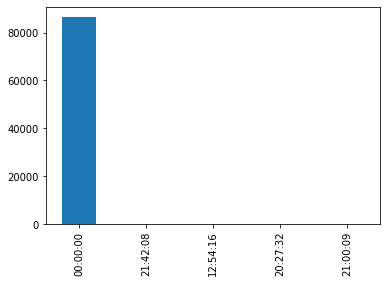

In [0]:
Tweets['time'].value_counts().head().plot.bar()

What are they?

In [0]:
Tweets[Tweets['time'] == '00:00:00']

,user_id,tweet_id,tweet,date/time,date,time,sentiment,location
7006,22398295.0,10172355714,"""From my vantage point, when it comes to money, women tend to lack confidence in their ability to do the (cont) http://tl.gd/entj8",2010-03-08,2010-03-08,00:00:00,"{'neg': 0.086, 'neu': 0.706, 'pos': 0.208, 'compound': 0.5106}",Los Angeles
7007,22398295.0,10138019709,"Hey Everyone, hope you are having a fabulous weekend... Call 213.446.5514 now for your chance to win $500 in Luxury Skin Care!",2010-03-07,2010-03-07,00:00:00,"{'neg': 0.0, 'neu': 0.506, 'pos': 0.494, 'compound': 0.9392}",Los Angeles
7008,22398295.0,10137947080,"@JuanaCombszvq I want legitimate followers not just any ole person, but Thank You",2010-03-07,2010-03-07,00:00:00,"{'neg': 0.0, 'neu': 0.694, 'pos': 0.306, 'compound': 0.5267}",Los Angeles
7009,22398295.0,10137899192,@wiretapper Thanks for the #FF,2010-03-07,2010-03-07,00:00:00,"{'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compound': 0.4404}",Los Angeles
7010,22398295.0,10100641017,My Second Published Article http://bit.ly/b7mSMy,2010-03-06,2010-03-06,00:00:00,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",Los Angeles
...,...,...,...,...,...,...,...,...
4944274,17416081.0,4115085688,I can see a family of Deer out for the foggy evening walk sitting here up in the hills...,2009-09-19,2009-09-19,00:00:00,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",Los Angeles
4944275,17416081.0,4087615529,@lilychandler oo good tips thank you. how many juices did you have a day?,2009-09-18,2009-09-18,00:00:00,"{'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'compound': 0.6597}",Los Angeles
4944276,17416081.0,4087599684,"@calaverita no...just kinda like a seasonal change thing...not really fasting, just cleansing and jump starting...",2009-09-18,2009-09-18,00:00:00,"{'neg': 0.0, 'neu': 0.855, 'pos': 0.145, 'compound': 0.2975}",Los Angeles
4944277,17416081.0,4083110187,"Correction, nate n al...um not sure where i put that E",2009-09-18,2009-09-18,00:00:00,"{'neg': 0.219, 'neu': 0.781, 'pos': 0.0, 'compound': -0.2411}",Los Angeles


Bot for most of them. We get rid of the probleme by droping post from 00:00:00 

In [0]:
Tweets = Tweets[Tweets['time'] != '00:00:00']

Filter to keep only tweet from 2009-04-01 to 2010-03-30

In [0]:
Tweets =Tweets[(Tweets['date/time'] >= '2009-04-01') & (Tweets['date/time'] <= '2010-03-30')]

We merge tweets en weather

First with hourly weather

In [0]:
Tweets=pd.read_pickle(tweet_datapath+'tweet+loc+sentiment-weather.pickle')
weather_hourly=pd.read_pickle(tweet_datapath+'meteo_csv/Weather_hourly')
dttweet=pd.to_datetime(Tweets['date/time'], utc= True)
Tweets['date/time'] = dttweet.apply(lambda dt:dt.replace(minute=0,second=0))
weather_hourly['date/time']=pd.to_datetime(weather_hourly['date/time'], utc= True)
tweet_hourly_weather = pd.merge(Tweets, weather_hourly,  how='left', left_on=['date/time','location'], right_on = ['date/time','location'])
tweet_daily_weather['date/time'] = pd.to_datetime(tweet_daily_weather['date'] +'/'+ tweet_daily_weather['time'])

Then with daily weather

In [0]:
Tweets=pd.read_pickle(tweet_datapath+'tweet+loc+sentiment-weather.pickle')
weather_daily=pd.read_pickle(tweet_datapath+'meteo_csv/Weather_daily')
dttweet=pd.to_datetime(Tweets['date/time'], utc= True)
Tweets['date/time'] = dttweet.apply(lambda dt:dt.replace(hour=0,minute=0,second=0))
weather_daily['date/time']=pd.to_datetime(weather_daily['date/time'], utc= True)
tweet_daily_weather = pd.merge(Tweets, weather_daily,  how='left', left_on=['date/time','location'], right_on = ['date/time','location'])
tweet_daily_weather['date/time'] = pd.to_datetime(tweet_daily_weather['date'] +'/'+ tweet_daily_weather['time'])

In [0]:
tweet_hourly_weather.to_pickle(tweet_datapath+'tweet+loc+sentiment+hourly_weather.pickle')
tweet_daily_weather.to_pickle(tweet_datapath+'tweet+loc+sentiment+daily_weather.pickle')

## Data Analysis

#### Aggregate data to allow a statistical analysis

In [0]:
Tweets=pd.read_pickle(tweet_datapath+"tweet+loc+sentiment-weather.pickle")

In [0]:
def set_compound(x):
  if(x>0.05):
    x=1
  elif(x<-0.05):
    x=-1
  else : 
    x=0
  return int(x) 

def average_sentiment_daily(df_sentiment):
    df = df_sentiment[df_sentiment['date/time'].apply(lambda datetime : datetime.hour>5)].copy()
    df['date/time']=df['date/time'].apply(lambda time : time.replace( hour=0,minute=0, second=0, microsecond=0))
    df_avg = pd.DataFrame(columns=df.columns)
    for ind_c,city in enumerate(df_sentiment['location'].unique()):
      for ind,time in enumerate(df['date/time'].unique()):
            
            df_it = df[(df['date/time'] == time) & (df['location'] == city)]
            df_avg.loc[ind+365*ind_c,'date/time']= time
            df_avg.loc[ind+365*ind_c,'location']= city
            if(df_it.shape[0]!=0):
              df_avg.loc[ind+ind_c*365,'%pos']= df_it[df_it['compound'] > 0].shape[0]/df_it.shape[0]#freq[1] # positive percent per day
            else:
              df_avg.loc[ind+ind_c*365,'%pos']=0
            if(df_it.shape[0]!=0): 
              df_avg.loc[ind+ind_c*365,'%neg']= df_it[df_it['compound'] < 0].shape[0]/df_it.shape[0]#freq[-1] # negative percent per day
            else: 
              df_avg.loc[ind+ind_c*365,'%neg']=0
            df_avg.loc[ind+ind_c*365,'n_tweet']= df_it.shape[0]
            df_avg.index = range(df_avg.shape[0])
    return df_avg.drop(columns=["user_id","tweet","date","time","tweet_id","sentiment",'compound'])

In [0]:
Tweets['compound']=Tweets.sentiment.map(lambda x : set_compound(x['compound']))

In [0]:
Tweets.sample(20)

,user_id,tweet_id,tweet,date/time,date,time,sentiment,location,compound
3346898,29242717.0,8750399404,@ROBBLOCKROYAL what's good my brother how's things? http://myloc.me/3zwJD,2010-02-06 22:00:00,2010-02-06,22:04:07,"{'neg': 0.0, 'neu': 0.707, 'pos': 0.293, 'compound': 0.4404}",New York,1
729748,66446500.0,9628907071,@MackieCharles I'm trying man...*,2010-02-25 08:00:00,2010-02-25,08:59:41,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",New York,0
283871,17285605.0,7628733261,"@WeArtisticWings My sister did that too, even tho she wanted to see the 2D.",2010-01-11 07:00:00,2010-01-11,07:08:41,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",New York,0
3461072,24639005.0,7877674455,would everybody be shocked if jets come out with the victory?,2010-01-17 15:00:00,2010-01-17,15:36:09,"{'neg': 0.187, 'neu': 0.813, 'pos': 0.0, 'compound': -0.3182}",New York,-1
3206737,23376992.0,10324977110,@MiyaBailey I would love to create a sketch for you,2010-03-11 08:00:00,2010-03-11,08:47:54,"{'neg': 0.0, 'neu': 0.488, 'pos': 0.512, 'compound': 0.743}",Atlanta,1
2076137,44567855.0,9863927162,@ClintRunNYC. Real niggas fuck with me and I don't give a fuck who don't! Welcome to the Mob Young Clint!!,2010-03-02 00:00:00,2010-03-02,00:48:52,"{'neg': 0.477, 'neu': 0.523, 'pos': 0.0, 'compound': -0.9145}",New York,-1
3869307,26093942.0,10049369891,Reh with UDA!! Love my uda fam :-),2010-03-05 18:00:00,2010-03-05,18:15:14,"{'neg': 0.0, 'neu': 0.459, 'pos': 0.541, 'compound': 0.7955}",New York,1
3950629,66500943.0,7882401662,Oowww touchdown!!!,2010-01-17 18:00:00,2010-01-17,18:07:29,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",New York,0
2646234,45969605.0,9596250671,Shawty Lo doing an interview @gyantunplugged http://tweetphoto.com/12398352,2010-02-24 16:00:00,2010-02-24,16:39:32,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",Atlanta,0
34659,27787319.0,5729843247,@gorgeousSOrare u got me beggin on twitter smh.....,2009-11-14 23:00:00,2009-11-14,23:52:40,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",New York,0


In [0]:
daily_score_tweets=average_sentiment_daily(Tweets)

In [0]:
daily_score_tweets = pd.read_pickle("/content/drive/Shared drives/ADA/Data_Tweets/data for stats/pos_neg_day")

,%pos,%neg,n_tweet,dpos
count,65.000000,65.000000,65.000000,65.000000
mean,0.445771,0.207771,1617.607692,-0.161259
std,0.018351,0.017005,681.478634,1.936911
min,0.375000,0.125000,0.750000,-3.905118
25%,0.435190,0.198830,1053.250000,-1.551524
50%,0.445051,0.207922,1576.500000,-0.046422
75%,0.456115,0.218552,2154.000000,1.173070
max,0.490890,0.239832,2775.500000,5.683090


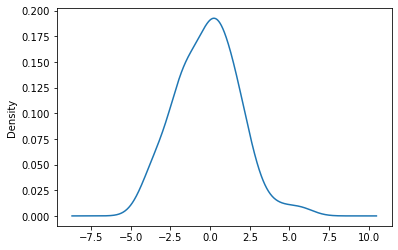

In [0]:
def plot_sentiment_by_weather(df,sentiment='%neg',weather=None)
if weather:
  no_city=daily_score_tweets[weather].drop(columns="location")
else :
  no_city=daily_score_tweets.drop(columns="location")
c=no_city.groupby(by="date/time").mean()
c["diff"]=c[sentiment].diff()

c=c.dropna()
c["dpos"]=c.dpos.map(lambda x: x*100)
c=c[(c.index.month < 4)&(c.index.day < 25) & (c.index.year> 2009) ]
c.dpos.plot.kde()
c.describe()

In [0]:
path_data = '/content/drive/Shared drives/ADA/Data_Tweets'
fig_size_ = [12,8]

#### First analysis of the dataset

In [0]:
path_data = '/content/drive/Shared drives/ADA/Data_Tweets'
fig_size_ = [12,8]

In [0]:
df_daily = pd.read_pickle('/content/drive/Shared drives/ADA/Data_Tweets/data for stats/LocDatePosNegWeatherClean')
df_daily.head()

%pos      %neg weather  n_tweet
location date/time                                      
Atlanta  2009-04-01  0.800000  0.200000  1       5.0    
         2009-04-02  0.428571  0.428571  1       7.0    
         2009-04-03  0.833333  0.000000  2       6.0    
         2009-04-04  0.000000  1.000000  2       1.0    
         2009-04-05  1.000000  0.000000  2       1.0

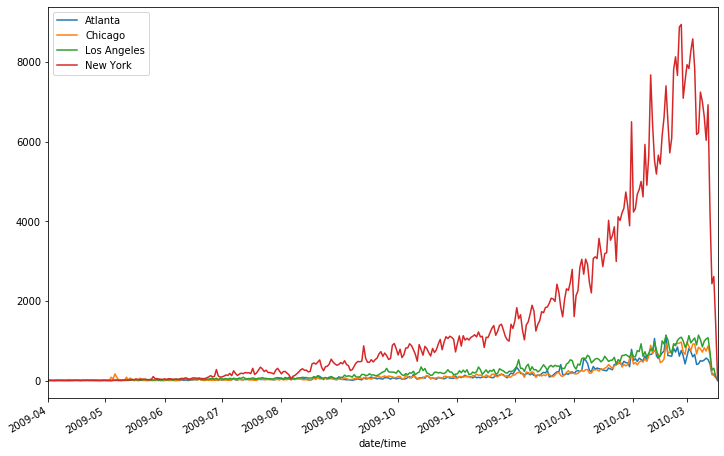

In [0]:
df = df_daily.reset_index()
df = df.set_index('location')
fig, ax = plt.subplots()
for label, grp in df.groupby('location'):
    grp.plot(x ='date/time', y = 'n_tweet', ax = ax, label = label,figsize=fig_size_)

This graph allow us to see the numbe of tweets as a function of time. We notice that the number of tweets are more frequent when we come closer to 2010. Therefore, we will only consider the time period from January to March. 

In [0]:
 df = df.loc[df['date/time']>= pd.to_datetime('2010, 1, 1')]
 df = df.loc[df['date/time']< pd.to_datetime('2010, 3, 1')]

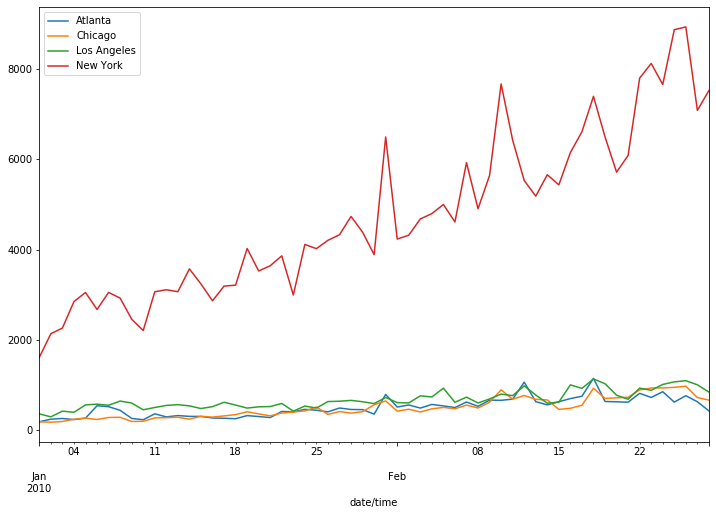

In [0]:
fig, ax = plt.subplots()
for label, grp in df.groupby('location'):
    grp.plot(x ='date/time', y = 'n_tweet', ax = ax, label = label,figsize=fig_size_ )

We could not completely address the problem we stated previously but the number of tweets per day are already much more frequent. 

([<matplotlib.axis.XTick at 0x7f1aa04c85c0>,
 <a list of 7 Text xticklabel objects>)

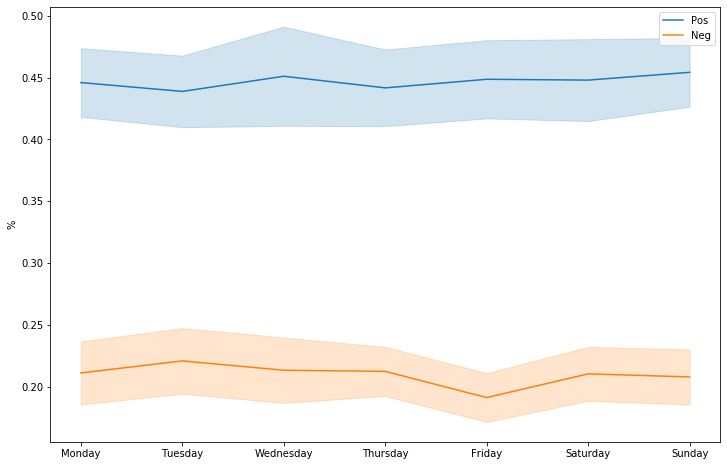

In [0]:
df['day_of_week'] = df['date/time'].dt.dayofweek
plt.figure(figsize=fig_size_)
ax = sns.lineplot(x="day_of_week", y="%pos",  ci='sd', data=df, legend='full')
sns.lineplot(x="day_of_week", y="%neg", ci='sd', data=df, legend='full')
ax.legend(['Pos','Neg'])
plt.ylabel('%')
plt.xlabel('')
plt.xticks(np.arange(7), ('Monday', 'Tuesday','Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday')) 

In this graph, we aggregated the data to analyse the percentage of positive and negative tweets over the week. We We can see, that on Friday people have the tendency to publish less negative tweets. We can not draw much more conclusions from this analyis.